In [1]:
import sys
sys.path.extend(['..', '../', '../..', '../../' ])
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from src.const import paths, datasets, networks
from src.parameters import metrics
from src.datasets.extract_part_of_dataset import DatasetPartExtractor
from src.datasets.dataset_generators import DatasetGenerators
from src.keras_callback.time_history import TimeHistory
from src.results.csv_export import export_learning_history_to_csv, export_learning_validation_result_to_csv
from src.results.model_export import clear_exported_models, get_best_model_from_directory
from src.results.result_plot import *
from src.keras_model.lenet5_network import LeNet5Network

Using TensorFlow backend.


# Setup basic params

In [3]:
network_name = networks.lenet5
network = LeNet5Network()
fit_epochs = 50
dataset = datasets.cifar10
dataset_percentage = 40

network.print_config()

Loss: <function categorical_crossentropy at 0x14d2fea70>
Metrics: ['accuracy', <function precision at 0x14d46ecb0>, <function recall at 0x14d46ed40>]
Image size: (32, 32)
Grayscale: True
Batch size: 32


# Extract given percentage of source dataset

In [4]:
DatasetPartExtractor().extract(dataset, dataset_percentage)

Checking if dataset exists in /Users/igor/Python/CNN-Architecture-Comparison/data/cifar10_40/
Dataset cifar10 already exists with 40% rate


# Setup dataset generators for train/test/validate sets

In [5]:
dataset_generators = DatasetGenerators(
    name=f'{dataset}_{dataset_percentage}',
    image_size=network.image_size,
    batch_size=network.batch_size,
    grayscale=network.grayscale
)


Loading train set for cifar10_40...
Found 14000 images belonging to 10 classes.
Loading test set for cifar10_40...
Found 4000 images belonging to 10 classes.
Loading validation set for cifar10_40...
Found 2000 images belonging to 10 classes.


# Compile model of network

In [6]:
model = network.get_compiled_model(
    classes=dataset_generators.test.num_classes
)

# Setup fitting callbacks

In [7]:
checkpoint_path = f'{paths.models_location}{network_name}/{dataset}/'
clear_exported_models(checkpoint_path)

best_callback = keras.callbacks.ModelCheckpoint(
    filepath=f'{checkpoint_path}{{epoch:02d}}-{{val_loss}}.h5',
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)

time_callback = TimeHistory()

model_callbacks = [best_callback, time_callback]

# Perform model fitting

In [8]:
fit_result = model.fit_generator(
    generator=dataset_generators.train,
    epochs=fit_epochs,
    validation_data=dataset_generators.test,
    callbacks = model_callbacks
)

Epoch 1/50
438/438 [==============================] - 7s 15ms/step - loss: 2.0143 - accuracy: 0.2579 - precision: 0.1138 - recall: 0.0473 - val_loss: 1.7779 - val_accuracy: 0.3232 - val_precision: 0.2440 - val_recall: 0.0922

Epoch 00001: val_loss improved from inf to 1.77794, saving model to /Users/igor/Python/CNN-Architecture-Comparison/models/lenet5/cifar10/01-1.7779407501220703.h5
Epoch 2/50
438/438 [==============================] - 5s 12ms/step - loss: 1.7583 - accuracy: 0.3667 - precision: 0.3977 - recall: 0.2037 - val_loss: 1.7645 - val_accuracy: 0.3887 - val_precision: 0.5514 - val_recall: 0.4259

Epoch 00002: val_loss improved from 1.77794 to 1.76453, saving model to /Users/igor/Python/CNN-Architecture-Comparison/models/lenet5/cifar10/02-1.764526605606079.h5
Epoch 3/50
438/438 [==============================] - 5s 12ms/step - loss: 1.6441 - accuracy: 0.4121 - precision: 0.4754 - recall: 0.2866 - val_loss: 2.0273 - val_accuracy: 0.4185 - val_precision: 0.4967 - val_recall: 0.2

# Retrieve best model found during fitting

In [9]:
best_saved_model_path = get_best_model_from_directory(checkpoint_path)
best_saved_model = keras.models.load_model(best_saved_model_path,
    custom_objects= {
        'precision': metrics.precision,
        'recall': metrics.recall
    }
)

# Evaluate best saved model

In [10]:
validation_result = best_saved_model.evaluate_generator(
    generator=dataset_generators.validate
)

# Results

### Epoch CSV

In [11]:
csv_file_path = f'{paths.results_location}{network_name}/{dataset}-history.csv'
export_learning_history_to_csv(csv_file_path, fit_result, time_callback.times)

epoch,time,val_loss,val_accuracy,val_precision,val_recall,loss,accuracy,precision,recall
0,0,0,0,0,0
1,6.547703981399536,1.7779407501220703,0.3232499957084656,0.24399998784065247,0.09222856909036636,2.0143165482112337,0.2579285800457001,0.11377473175525665,0.04733366146683693
2,5.47182297706604,1.764526605606079,0.38874998688697815,0.5513999462127686,0.42586222290992737,1.758498510496957,0.3667142987251282,0.39773592352867126,0.2037181705236435
3,5.31669020652771,2.027261257171631,0.41850000619888306,0.49666666984558105,0.2325524091720581,1.6442327954428537,0.41207143664360046,0.4753778576850891,0.28664836287498474
4,5.259996175765991,1.6084966659545898,0.4087499976158142,0.32399997115135193,0.14178095757961273,1.5388497634615217,0.4520714282989502,0.5483638048171997,0.3489183187484741
5,5.833872079849243,1.8123199939727783,0.4205000102519989,0.47333329916000366,0.1957523673772812,1.4662916548592704,0.4804285764694214,0.5629159808158875,0.369268536567688
6,5.222856044769287,1.414085865

### Epoch plots

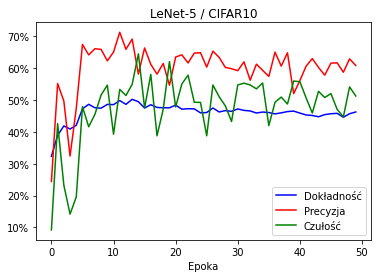

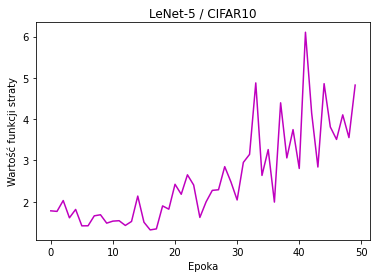

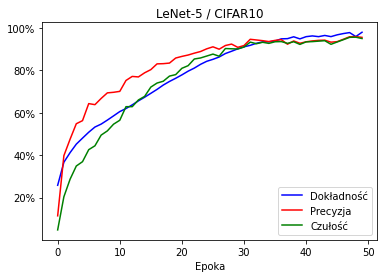

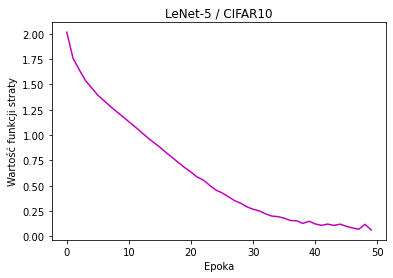

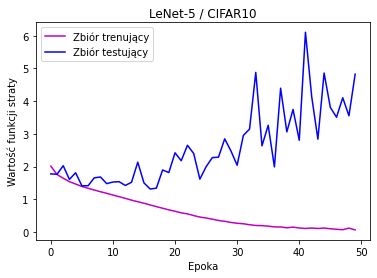

In [12]:
val_metrics_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-val-metrics.png'
val_loss_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-val-loss.png'
metrics_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-metrics.png'
loss_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-loss.png'
loss_comparison_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-loss-comparison.png'

plot_learning_history_val_metrics(val_metrics_png_file_path, network_name, dataset, fit_result)
plot_learning_history_val_loss(val_loss_png_file_path, network_name, dataset, fit_result)
plot_learning_history_metrics(metrics_png_file_path, network_name, dataset, fit_result)
plot_learning_history_loss(loss_png_file_path, network_name, dataset, fit_result)
plot_loss_comparison(loss_comparison_png_file_path, network_name, dataset, fit_result)

### Validation result CSV

In [13]:
csv_file_path = f'{paths.results_location}{network_name}/{dataset}-result.csv'
export_learning_validation_result_to_csv(csv_file_path, validation_result, time_callback.times)

avg_epoch_time,time,val_loss,val_accuracy,val_precision,val_recall
5.173640155792237,258.6820077896118,1.086021065711975,0.5,0.5963339805603027,0.5948601961135864
